In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd

In [2]:
df = pd.read_csv("zipCode_48.csv")

In [3]:
df.head()

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,98357,PO BOX,NEAH BAY,WA,PRIMARY,48.33,-124.63,NA-US-WA-NEAH BAY,False,473.0,877.0,12642512.0
1,98350,PO BOX,LA PUSH,WA,PRIMARY,47.90,-124.61,NA-US-WA-LA PUSH,False,NaN,NaN,NaN
2,98326,STANDARD,CLALLAM BAY,WA,PRIMARY,48.17,-124.53,NA-US-WA-CLALLAM BAY,False,NaN,NaN,NaN
3,97464,PO BOX,OPHIR,OR,PRIMARY,42.50,-124.41,NA-US-OR-OPHIR,False,NaN,NaN,NaN
4,97491,PO BOX,WEDDERBURN,OR,PRIMARY,42.45,-124.40,NA-US-OR-WEDDERBURN,False,NaN,NaN,NaN


In [4]:
df.isnull().sum()

Zipcode                    0
ZipCodeType                0
City                       0
State                      0
LocationType               0
Lat                        0
Long                       0
Location                   0
Decommisioned              0
TaxReturnsFiled        12043
EstimatedPopulation    12043
TotalWages             12078
dtype: int64

In [5]:
df = df.drop(columns = ['TaxReturnsFiled','EstimatedPopulation','TotalWages','ZipCodeType','Decommisioned','LocationType','Location','City'])


<AxesSubplot:xlabel='Long', ylabel='Lat'>

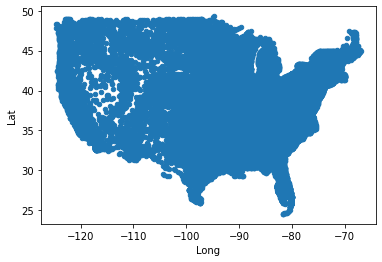

In [6]:
df.plot(x="Long", y="Lat", kind="scatter")

In [7]:
states = gpd.read_file('tl_2020_us_state.shp')
states = states.to_crs("EPSG:4326")

In [8]:
states.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266296765,489206049,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138958484319,45975808217,+28.3989775,-082.5143005,"MULTIPOLYGON (((-86.39964 30.22696, -86.40262 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778461053,6216594318,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232157570,18949864226,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151895765,6979171386,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


<AxesSubplot:>

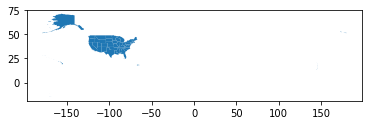

In [9]:
states.plot()

<AxesSubplot:>

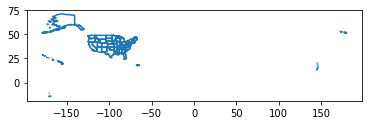

In [10]:
states.boundary.plot()

In [11]:
non_continental = ['AK','HI','PR','MP','VI','GU','AS']
us49 = states
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

<AxesSubplot:>

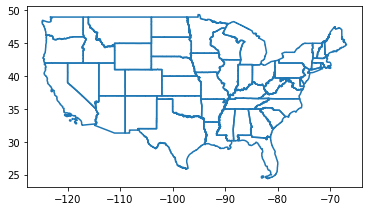

In [12]:
us49.boundary.plot()

In [13]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Long, df.Lat))

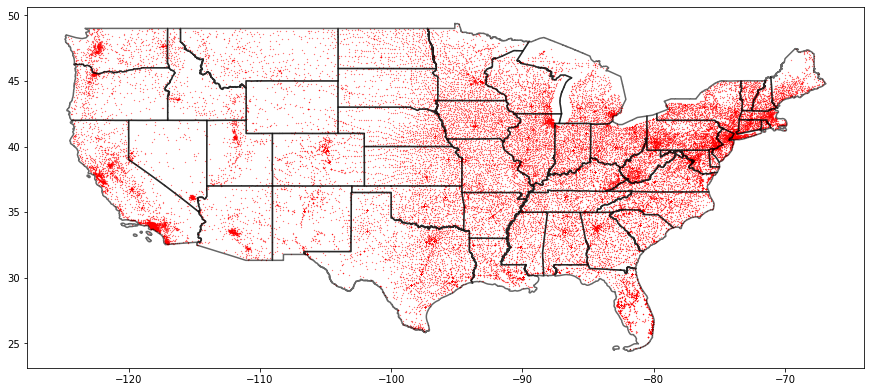

In [15]:
fig,ax=plt.subplots(figsize=(15,15))
us49.boundary.plot(ax=ax, color='black',alpha=0.6)
gdf.plot(ax=ax, color='red', marker='.', markersize=0.2)
plt.show()

In [16]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [17]:
#convert latitude and longitude columns into two dimensional numpy array
coordinates = gdf[['Lat','Long']].values 

In [18]:
# epsilon is the max distance between two zipcodesand min_sample in the minimum cluster size
#haversine and ball tree algorithm is used to calculate great circle distance between zipcodes
kms_per_radian = 6371.0088
epsilon = 1.5/kms_per_radian  
db = DBSCAN(eps = epsilon, min_samples = 5, algorithm ='ball_tree', metric ='haversine').fit(np.radians(coordinates))
cluster_labels=db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coordinates[cluster_labels==n] for n in range(num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 484


In [19]:
# it returns the center most point from the cluster that is centroid
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [20]:
Lats, Longs = zip(*centermost_points)
representative_points = pd.DataFrame({'Lat':Lats,'Long':Longs})

In [21]:
rs = representative_points.apply(lambda row: gdf[(gdf['Lat']==row['Lat']) & (gdf['Long']==row['Long'])].iloc[0], axis =1)

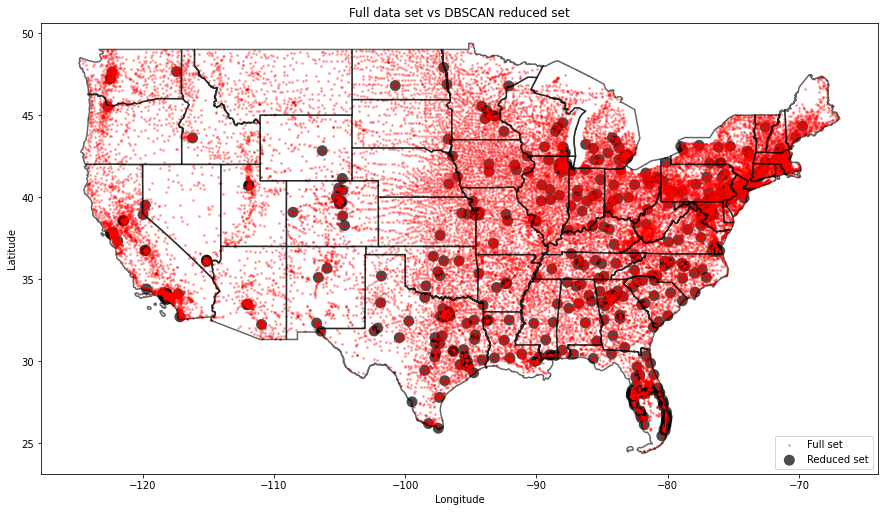

In [22]:
fig,ax = plt.subplots(figsize=[15, 10])
us49.boundary.plot(ax=ax, color='black',alpha=0.6)
rs_scatter = ax.scatter(rs['Long'], rs['Lat'], c='#000000', edgecolor='None', alpha=0.7, s=120) #Converting Colors - Hex - 99CC99
gdf_scatter = ax.scatter(gdf['Long'], gdf['Lat'], c='r', alpha=0.3, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([gdf_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

In [23]:
from shapely.geometry import Polygon
import matplotlib.cm as cm, matplotlib.font_manager as fm

In [24]:
title_font = fm.FontProperties(family='Arial', style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family='Arial', style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family='Arial', style='normal', size=12, weight='normal', stretch='normal')
annotation_font = fm.FontProperties(family='Arial', style='normal', size=11, weight='normal', stretch='normal')

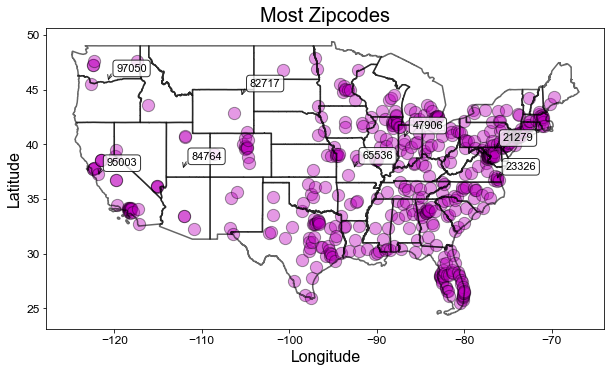

In [25]:
most_index = gdf['Zipcode'].value_counts().head(8).index
most = pd.DataFrame(gdf[gdf['Zipcode'].isin(most_index)])
most.drop_duplicates(subset=['Zipcode'], keep='first', inplace=True)

# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['Long'], rs['Lat'], c='m', edgecolor='k', alpha=.4, s=150)
us49.boundary.plot(ax=ax, color='black',alpha=0.6)

# set axis labels, tick labels, and title
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)
ax.set_title('Most Zipcodes', fontproperties=title_font)
ax.set_xlabel('Longitude', fontproperties=label_font)
ax.set_ylabel('Latitude', fontproperties=label_font)

# annotate the most visited cities
for _, row in most.iterrows():
    ax.annotate(row['Zipcode'], 
                xy=(row['Long'], row['Lat']),
                xytext=(row['Long'] + 1, row['Lat'] + 1),
                fontproperties=annotation_font,
                bbox=dict(boxstyle='round', color='k', fc='w', alpha=0.8),
                xycoords='data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='k', alpha=0.8))
plt.show()

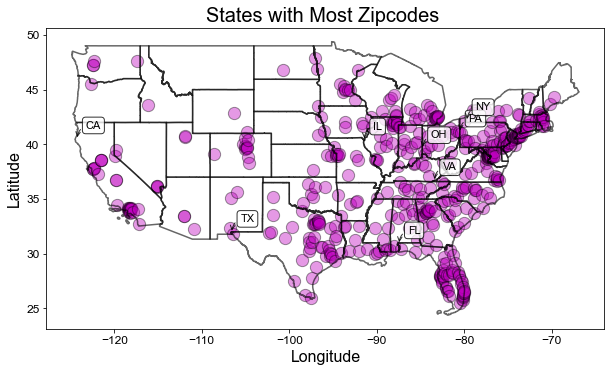

In [26]:
most_index = gdf['State'].value_counts().head(8).index
most = pd.DataFrame(gdf[gdf['State'].isin(most_index)])
most.drop_duplicates(subset=['State'], keep='first', inplace=True)

# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['Long'], rs['Lat'], c='m', edgecolor='k', alpha=.4, s=150)
us49.boundary.plot(ax=ax, color='black',alpha=0.6)

# set axis labels, tick labels, and title
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)
ax.set_title('States with Most Zipcodes ', fontproperties=title_font)
ax.set_xlabel('Longitude', fontproperties=label_font)
ax.set_ylabel('Latitude', fontproperties=label_font)

# annotate the most visited cities
for _, row in most.iterrows():
    ax.annotate(row['State'], 
                xy=(row['Long'], row['Lat']),
                xytext=(row['Long'] + 1, row['Lat'] + 1),
                fontproperties=annotation_font,
                bbox=dict(boxstyle='round', color='k', fc='w', alpha=0.8),
                xycoords='data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='k', alpha=0.8))
plt.show()